# Notes for user:

*   This notebook will use the dataset COVID-19 (positive cases and death rates) and forex to predict the forex spot price of a currency pair.
*   What to ask user before using this application:
*   What currency pair are you interested in? GBP/USD (This layout means that the base currency is USD)
*   The currency the user wants to look at is how much the USD is worth to the GBP.
*   Therefore, we look at the death rates & positive cases in the US.
*   We are looking at dates: 31st Dec 2019 - 31st July 2020.
*   LSTMs are good at looking at changed over time. 


# Part 2B: Multivariate CNN 


*   I will be converting a conventional tabular or time-series data to image, and training a classification model on it.
*  I will use a novel CNN model using a 2-D convolutional neural network based on image processing properties. 
*  In order to convert a dataset time series into 2-D images, 3 different datasets will be used i.e. covid positive cases, covid deaths and forex price. These three features will be fused together, each instance generates data for a 7 day period. As a result, 7 × 3 sized 2-D images are constructed. 
*  Then train a Convolutional Neural Network like any other image classification problem.


# Imports

In [ ]:
# Imports
!pip install git+https://github.com/tensorflow/docs
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
#plotting
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams
# metrics
import math
# to create model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer, Dense, LSTM, Dropout

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-2u2mq7vw
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-2u2mq7vw
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.06cc84213c3b6a0826b1773f5ee09eec0c1bcad22_-cp36-none-any.whl size=127319 sha256=bf6166d97c681862517c0784bd7dbb11b8b971012c1e5984d3ee6a9957fb5135
  Stored in directory: /tmp/pip-ephem-wheel-cache-qnfzreid/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
2.3.0


In [ ]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Data Collection


In [ ]:
# Importing covid_dataset using pandas. Droping null values.
covid_dataset_data= pd.read_csv('owid_covid_data.csv', na_values = "?", comment='\t', skipinitialspace=True)
covid_dataset = covid_dataset_data.copy()
# covid_dataset = covid_dataset.dropna()  
# We do not want to drop empty tables as this is null values are part of our dataset
covid_dataset.head()

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,0.0,0.0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
1,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.0,0.0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.33,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
2,ABW,North America,Aruba,2020-03-24,12.0,8.0,0.0,0.0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.44,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
3,ABW,North America,Aruba,2020-03-25,17.0,5.0,0.0,0.0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.44,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
4,ABW,North America,Aruba,2020-03-26,19.0,2.0,0.0,0.0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.44,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29


In [ ]:
# Trying to isolate location based on currency in question
us_death_rates = covid_dataset.loc[covid_dataset.location=='United States', ['location', 'date', 'total_cases', 'total_deaths']]
us_death_rates.head()

,location,date,total_cases,total_deaths
32403,United States,2019-12-31,0.0,0.0
32404,United States,2020-01-01,0.0,0.0
32405,United States,2020-01-02,0.0,0.0
32406,United States,2020-01-03,0.0,0.0
32407,United States,2020-01-04,0.0,0.0


In [ ]:
# Import forex
forex_dataset_data= pd.read_csv('GBP_USD.csv', na_values = "?", comment='\t', skipinitialspace=True)
forex_dataset = forex_dataset_data.copy()
forex_dataset = forex_dataset.fillna(method='ffill')
# forex_dataset = forex_dataset_data.dropna()

In [ ]:
# Why are these different?
print(us_death_rates.shape), print(forex_dataset.shape)

(218, 4)
(214, 6)


(None, None)

# Data Preprocessing / Data Cleaning & Collating
*   Eliminating columns we dont want
*   Merging tables based on 'Date' column
*   Dates in question: Dec 31 2019 - Jul 31, 2020
*   Once complete we pop the 'date' we merged on 

In [ ]:
# Filter dataset
forex_dataset.pop('Open')
forex_dataset.pop('High')
forex_dataset.pop('Low')
forex_dataset.pop('Change %')

0      -0.04%
1       0.76%
2       0.49%
3       0.38%
4       0.72%
        ...  
209     0.62%
210    -0.44%
211    -0.82%
212    -0.05%
213     1.11%
Name: Change %, Length: 214, dtype: object

In [ ]:
# Isolate covid_date
import time 
us_date = us_death_rates['date']
new_us_dates = [time.strptime(x.replace("-"," "), '%Y %m %d')for x in us_date]
us_death_rates['date'] = new_us_dates
us_death_rates.head()


,location,date,total_cases,total_deaths
32403,United States,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",0.0,0.0
32404,United States,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",0.0,0.0
32405,United States,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",0.0,0.0
32406,United States,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",0.0,0.0
32407,United States,"(2020, 1, 4, 0, 0, 0, 5, 4, -1)",0.0,0.0


In [ ]:
# Isolate forex_date
import time 
forex_date = forex_dataset['Date']
new_forex_dates = [time.strptime(x.replace(',', ""), '%b %d %Y')for x in forex_date]
forex_dataset['Date'] = new_forex_dates
forex_dataset.tail()


,Date,Price
209,"(2020, 1, 4, 0, 0, 0, 5, 4, -1)",1.3169
210,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",1.3088
211,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",1.3146
212,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",1.3255
213,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",1.3261


In [ ]:
# Merging dates from two tables
dataset = pd.merge(left=forex_dataset, left_on='Date',
         right=us_death_rates, right_on='date')
dataset.tail()
print(dataset)
len(dataset)

                                    Date   Price  ... total_cases total_deaths
0     (2020, 7, 31, 0, 0, 0, 4, 213, -1)  1.3090  ...   4495014.0     152070.0
1     (2020, 7, 30, 0, 0, 0, 3, 212, -1)  1.3095  ...   4426982.0     150713.0
2     (2020, 7, 29, 0, 0, 0, 2, 211, -1)  1.2996  ...   4351997.0     149256.0
3     (2020, 7, 28, 0, 0, 0, 1, 210, -1)  1.2932  ...   4290263.0     148011.0
4     (2020, 7, 27, 0, 0, 0, 0, 209, -1)  1.2882  ...   4234020.0     146935.0
..                                   ...     ...  ...         ...          ...
209      (2020, 1, 4, 0, 0, 0, 5, 4, -1)  1.3169  ...         0.0          0.0
210      (2020, 1, 3, 0, 0, 0, 4, 3, -1)  1.3088  ...         0.0          0.0
211      (2020, 1, 2, 0, 0, 0, 3, 2, -1)  1.3146  ...         0.0          0.0
212      (2020, 1, 1, 0, 0, 0, 2, 1, -1)  1.3255  ...         0.0          0.0
213  (2019, 12, 31, 0, 0, 0, 1, 365, -1)  1.3261  ...         0.0          0.0

[214 rows x 6 columns]


214

In [ ]:
# We pop the 'date' from the covid_dataset because this column starts later than the forex column
# We want to see the forex price before covid happened
dataset.pop('date')

0       (2020, 7, 31, 0, 0, 0, 4, 213, -1)
1       (2020, 7, 30, 0, 0, 0, 3, 212, -1)
2       (2020, 7, 29, 0, 0, 0, 2, 211, -1)
3       (2020, 7, 28, 0, 0, 0, 1, 210, -1)
4       (2020, 7, 27, 0, 0, 0, 0, 209, -1)
                      ...                 
209        (2020, 1, 4, 0, 0, 0, 5, 4, -1)
210        (2020, 1, 3, 0, 0, 0, 4, 3, -1)
211        (2020, 1, 2, 0, 0, 0, 3, 2, -1)
212        (2020, 1, 1, 0, 0, 0, 2, 1, -1)
213    (2019, 12, 31, 0, 0, 0, 1, 365, -1)
Name: date, Length: 214, dtype: object

In [ ]:
dataset.head()

,Date,Price,location,total_cases,total_deaths
0,"(2020, 7, 31, 0, 0, 0, 4, 213, -1)",1.3090,United States,4495014.0,152070.0
1,"(2020, 7, 30, 0, 0, 0, 3, 212, -1)",1.3095,United States,4426982.0,150713.0
2,"(2020, 7, 29, 0, 0, 0, 2, 211, -1)",1.2996,United States,4351997.0,149256.0
3,"(2020, 7, 28, 0, 0, 0, 1, 210, -1)",1.2932,United States,4290263.0,148011.0
4,"(2020, 7, 27, 0, 0, 0, 0, 209, -1)",1.2882,United States,4234020.0,146935.0


# Plotting Features before Normalisation

## Organising date for plotting

In [ ]:
# View what date looks like
# Splitting timestamp and isolating the date
date = dataset['Date']
dateFormatting = pd.DataFrame({'new_date': pd.date_range('2019-12-31', '2020-07-31', periods=len(date))})
print(dateFormatting)

      new_date
0   2019-12-31
1   2020-01-01
2   2020-01-02
3   2020-01-03
4   2020-01-04
..         ...
209 2020-07-27
210 2020-07-28
211 2020-07-29
212 2020-07-30
213 2020-07-31

[214 rows x 1 columns]


In [ ]:
# Convert date to list so that we can use the dates to plot on graph
my_xticks = dateFormatting['new_date'].tolist()
# print(my_xticks)

## Plotting Forex Spot Price

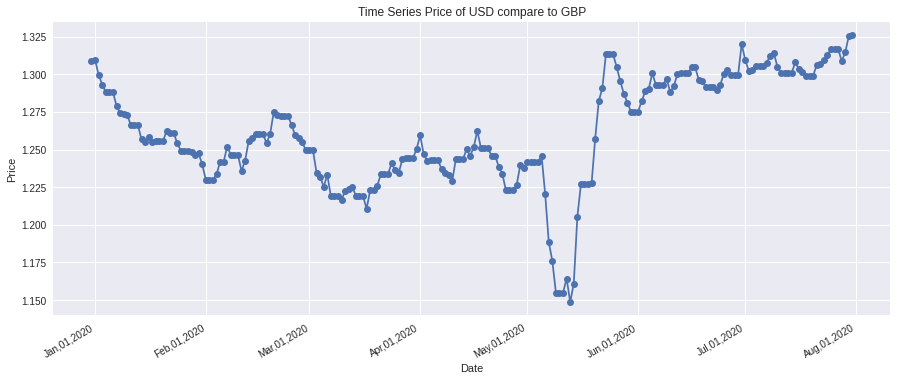

In [ ]:
# Plotted prices and dates
# Notice how the dates start and end

rcParams['figure.figsize'] = 15,6
dates = np.array(dateFormatting['new_date'])
price = np.array(dataset['Price'])
plt.plot_date(dates,price, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series Price of USD compare to GBP')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(date_format)

## Plotting Accumulative Covid Deaths

In [ ]:
# Adds the accumulative deaths every day of a country
# Problem – This needs to be sorted from the end since the way out data is set up - can this be made more efficient?
total_us_deaths = dataset['total_deaths']
list_arr = np.array(total_us_deaths)
reversed_arr = list_arr[::-1]
newDayDeaths = 0
dayDeaths = []
for currentday in reversed_arr:
   newDayDeaths = currentday + newDayDeaths
   dayDeaths.append(newDayDeaths)


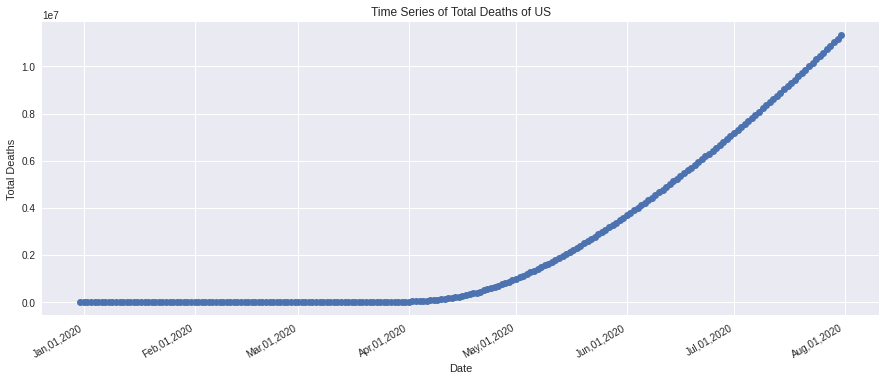

In [ ]:
# Plots the accumulative daily death rates of a country
dates = np.array(dateFormatting['new_date'])
us_deaths = np.array(dayDeaths)
plt.plot_date(dates, us_deaths, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Total Deaths of US')
plt.xlabel('Date')
plt.ylabel('Total Deaths')
plt.gca().xaxis.set_major_formatter(date_format)



## Plotting Accumulative Positive Cases

In [ ]:
# Adds accumulative positive cases everyday
total_us_cases = dataset['total_cases']
list_arr = np.array(total_us_cases)
reversed_arr = list_arr[::-1]
newDayCases = 0
dayCases = []
for currentday in reversed_arr:
   newDayCases = currentday + newDayCases
   dayCases.append(newDayCases)

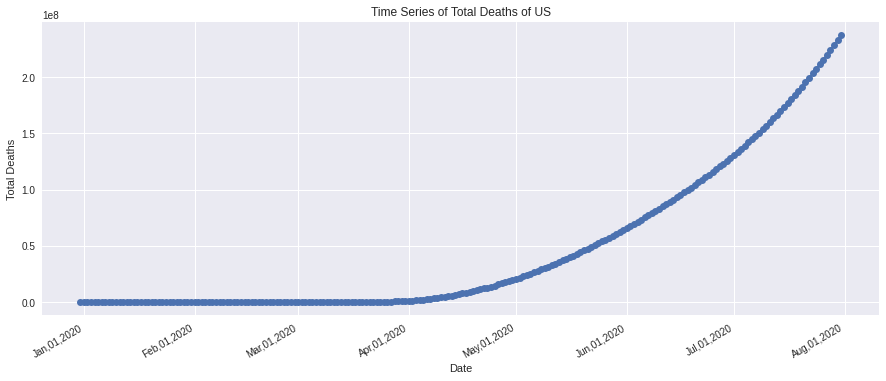

In [ ]:
# Plots the accumulative daily death rates of a country
dates = np.array(dateFormatting['new_date'])
us_cases = np.array(dayCases)
plt.plot_date(dates, us_cases, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Total Deaths of US')
plt.xlabel('Date')
plt.ylabel('Total Deaths')
plt.gca().xaxis.set_major_formatter(date_format)

# Plotting Features after Normalisation

In [ ]:
price_frame = pd.DataFrame(np.concatenate([price]), columns= ["Price"])
death_frame = pd.DataFrame(np.concatenate([dayDeaths]), columns= ["Total_Deaths_US"])
cases_frame = pd.DataFrame(np.concatenate([dayCases]), columns= ["Total_Cases_US"])
# price_frame.append(death_frame)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
normalisation_us_deaths = scaler.fit_transform(death_frame).reshape(-1,1)
normalisation_price = scaler.fit_transform(price_frame).reshape(-1,1)
normalisation_us_cases = scaler.fit_transform(cases_frame).reshape(-1,1)
# 8 decimal: readable formate:
# val = [print("{:.8f}".format(float(x)))for x in normalisation_us_deaths]

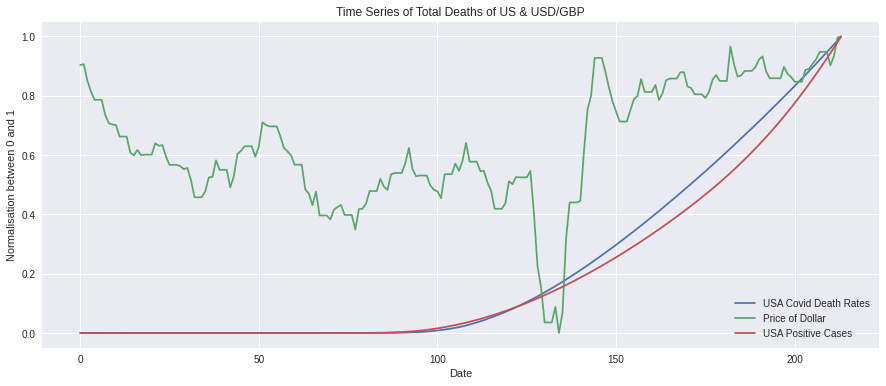

In [ ]:
plt.plot(normalisation_us_deaths,label="USA Covid Death Rates")
plt.plot(normalisation_price, label="Price of Dollar")
plt.plot(normalisation_us_cases, label="USA Positive Cases")

# dates
# dates = np.array(dateFormatting['new_date'])
# plt.plot_date(dates, linestyle ='solid')
# plt.gcf().autofmt_xdate()
# date_format = mpl_dates.DateFormatter('%b,%d,%Y')
# plt.gca().xaxis.set_major_formatter(date_format)

plt.title('Time Series of Total Deaths of US & USD/GBP')
plt.ylabel('Normalisation between 0 and 1')
plt.xlabel('Date')
plt.legend() 
plt.show()


# Splitting Data into Train, Validation & Test


In [ ]:
# Creating normalised dataset
# Positive Cases | Death Rates | Price of dollar
new_dataset = np.hstack((normalisation_us_cases, normalisation_us_deaths, normalisation_price))

In [ ]:
# Test, Validation, Train 
# This should be ordered in respect to date – not cross validation or random seed
# We are going to divide our data based on date because the next data is always dependent on the previous data
# 65% of the total length of my datadrame
# 35% validation/test size/ 
training_size = int(len(new_dataset)*0.80)
test_size = (len(new_dataset)-training_size)//2 # // Rounds down
train_data, valset_data, test_data = new_dataset[0:training_size], new_dataset[training_size:(training_size + test_size)],new_dataset[(training_size + test_size):]
print(train_data.shape)
print(valset_data.shape)
print(test_data.shape)

(171, 3)
(21, 3)
(22, 3)


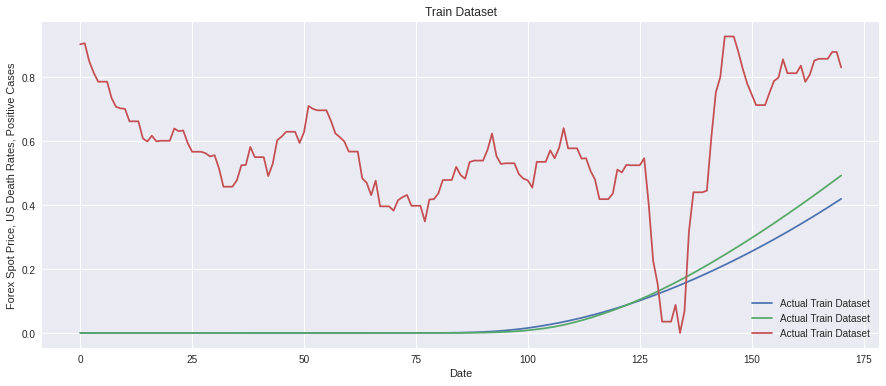

In [ ]:
# Start
plt.plot(train_data, label="Actual Train Dataset")
plt.title('Train Dataset')
plt.ylabel('Forex Spot Price, US Death Rates, Positive Cases')
plt.xlabel('Date')
plt.legend()
plt.show()




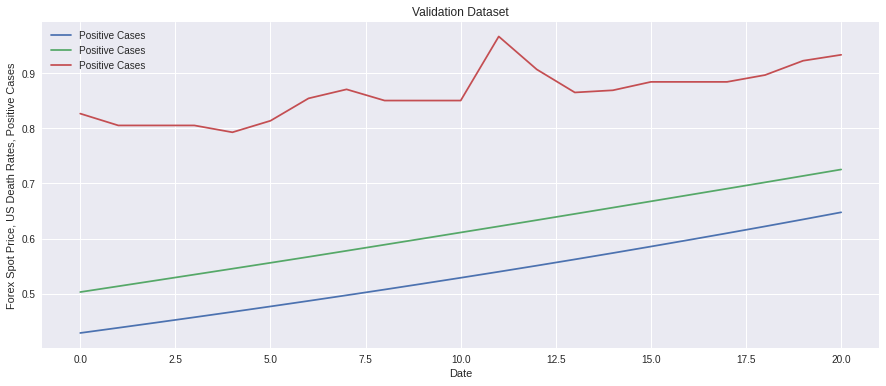

In [ ]:
# Middle
plt.plot(valset_data, label="Positive Cases")
plt.title('Validation Dataset')
plt.ylabel('Forex Spot Price, US Death Rates, Positive Cases')
plt.xlabel('Date')
plt.legend()
plt.show()

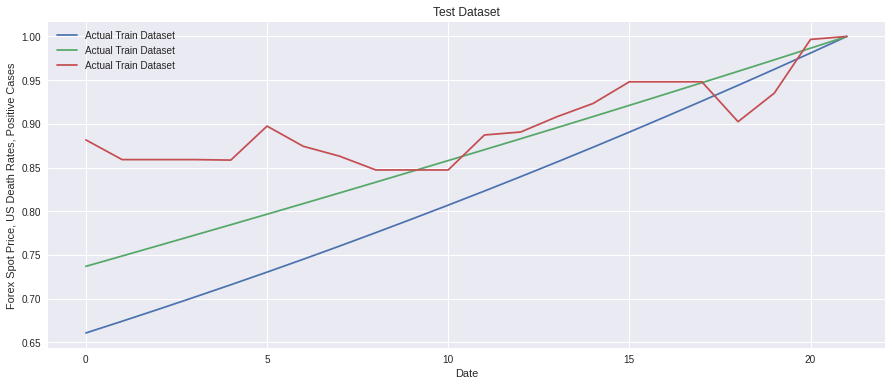

In [ ]:
# End
plt.plot(test_data, label="Actual Train Dataset")
plt.title('Test Dataset')
plt.ylabel('Forex Spot Price, US Death Rates, Positive Cases')
plt.xlabel('Date')
plt.legend()
plt.show()

# X_train, Y_train, X_test, Y_test

In [ ]:
# Convert an array of values into a dataset matrix
# time_step = how many previous days you have to consider before making a prediction. = 1 passing by ref
def create_dataset(dataset, time_step=1):
  dataX, dataY = [],[]
  # len(dataset) = 154 - 7 = 147 -1 (guarentees 8th datapoint)
  # for i(starting point of dataset), i in range 146
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step)]  # from i: until i + 7
    dataX.append(a) # then attach it to dataX
    y = dataset[i + time_step][2]  # attach the feature index 2 which is forex of 3 data predictions to y
    dataY.append(y)
  return np.array(dataX), np.array(dataY)


In [ ]:
# Weekly_timestep means taking in 7 days of features at a time 
weekly_timestep = 7
X_train, Y_train = create_dataset(train_data, weekly_timestep)
X_val, Y_val = create_dataset(valset_data, weekly_timestep)
X_test, Y_test = create_dataset(test_data, weekly_timestep)



In [ ]:
print(X_test.shape), print(Y_test.shape)
# Finished preprocessing the data

(14, 7, 3)
(14,)


(None, None)

# Reshape data to input into CNN

In [ ]:
print(X_train.shape), print(Y_train.shape)
print(X_train.shape), print(Y_train.shape)
# Finished preprocessing the data

(163, 7, 3)
(163,)
(163, 7, 3)
(163,)


(None, None)

In [ ]:
X_train = X_train.reshape(163,7,3,1)
X_val = X_val.reshape(13,7,3,1)
X_test = X_test.reshape(14,7,3,1)


print(X_train.shape), print(Y_train.shape)
print(X_val.shape), print(Y_val.shape)
print(X_test.shape), print(Y_test.shape)

(163, 7, 3, 1)
(163,)
(13, 7, 3, 1)
(13,)
(14, 7, 3, 1)
(14,)


(None, None)

# CNN Model

In [ ]:
# stide/steps = 1 day at a time
  # activation = none
  # kernal side how mnay days you want to look at
  # filter: number of nodes you can extract?
  # a filter is a collection of kernels
  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, Flatten, Dropout

def cnn_model(lr_rate, filters_layers, optimizer_one):

  opt = None
  if optimizer_one == 'adam':
   opt = keras.optimizers.Adam(learning_rate=lr_rate)
  elif optimizer_one == 'sgd':
   opt = keras.optimizers.SGD(learning_rate=lr_rate)
  else:
   opt = keras.optimizers.Adamax(learning_rate=lr_rate)

  cnn = Sequential([
    
  Conv2D(filters= filters_layers, input_shape=(7, 3, 1), kernel_size=(1,1), strides=1),
  Dropout(0.2),
  Conv2D(filters= filters_layers, kernel_size=(1,1), strides=1),
  Dropout(0.2),
  Dense(5), #
  Flatten(), # to make 1D
  Dense(1) # output feature map
  ])
  cnn.compile(loss = 'mean_squared_error', optimizer= opt)
  # print(cnn.summary())
  return cnn
  

## Hyperparameter Tuning


*   Optimizers:
[Overview of different Optimizers for neural networks](https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3#:~:text=Adagrad%20eliminates%20the%20need%20to,is%20no%20longer%20able%20learning.)
*   [Conceptual Guide for HP Tuning](https://medium.com/@jackstalfort/hyperparameter-tuning-using-grid-search-and-random-search-f8750a464b35)
*   [Consider this for Grid Search & Random Search](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html)
*   [And this](https://stackoverflow.com/questions/58137140/randomizedsearchcv-with-keras-lstm-regression)
![Grid Search & Random Search](https://miro.medium.com/max/1200/1*ZTlQm_WRcrNqL-nLnx6GJA.png)



In [ ]:
# Function to create the best model for hyperparameters method
def bestModel(least_loss, learning_rate_list, optimizer_list, filter_list):
  for each_filter in filter_list:
    for each_optimizer in optimizer_list:
      for each_learning_rate in learning_rate_list:
        our_model = cnn_model(each_learning_rate, each_filter, each_optimizer)
        our_model.fit(X_train, Y_train, 
                validation_data= 
                (X_val, Y_val)
                , epochs=100,batch_size=10,verbose=1,
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])
        loss = our_model.evaluate(X_test, Y_test)
        if loss < least_loss:
          least_loss = loss
          best_learning_rate = each_learning_rate
          best_optimizer = each_optimizer
          best_filter= each_filter
    return least_loss, best_learning_rate, best_optimizer, best_filter

## Grid Search

*   We must choose candidates for good hidden layers and optimizers. Then plot a comparison.
*   List of optimizers: 
*   optimizers = ['SGD', 'RMSprop','adam','adagrad', 'adadelta', 'adamax','nadam', 'ftrl']
*   Callbacks: Restores best weights that is going to give u best model 
*   Consider changing batch size: slower the batch_size better training, because small dataset




In [ ]:
filter_list = [15,30,10]
optimizer_list = ['adam', 'adamax']
learning_rate_list = [3e-3,3e-4]
least_loss_grid_search = 1

best_grid_search_model = bestModel(least_loss_grid_search, learning_rate_list, optimizer_list, filter_list)
print(best_grid_search_model)


Epoch 1/100
17/17 [==============================] - 0s 14ms/step - loss: 0.1538 - val_loss: 0.0184
Epoch 2/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0431 - val_loss: 0.0091
Epoch 3/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0282 - val_loss: 0.0094
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0265 - val_loss: 0.0021
Epoch 5/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0218 - val_loss: 0.0015
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0223 - val_loss: 0.0039
Epoch 7/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0190 - val_loss: 0.0018
Epoch 8/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0223 - val_loss: 0.0014
Epoch 9/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0188 - val_loss: 0.0085
Epoch 10/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0186 - val_loss: 0.0234
Epoch 11

## Random Search


*   Why do we get different values here then we do for grid search? Shouldnt they be the same?



In [ ]:
# Shuffle hidden_layer list
from random import seed
from random import shuffle


In [ ]:
# Shuffling filter layers

filter_list = [15,30,10]
# Seed random number generator
seed(len(filter_list))
# Prepare a sequence
filter_sequence = filter_list
print(filter_sequence) # Before Shuffle
# Randomly shuffle the sequence hidden layers
shuffle(filter_sequence) 
print(filter_sequence) # After Shuffle

# Shuffling optimizers

optimizer_list = ['adam', 'adamax']
# Seed random number generator
seed(len(filter_sequence))
# Prepare a sequence
op_sequence = optimizer_list
print(op_sequence) # Before Shuffle
# Randomly shuffle the sequence
shuffle(op_sequence)
print(op_sequence) # After Shuffle

# Shuffling learning rate

learning_rate_list = [3e-3,3e-4]
# Seed random number generator
seed(len(filter_sequence))
# Prepare a sequence
lr_sequence = learning_rate_list
print(lr_sequence) # Before Shuffle
# Randomly shuffle the sequence
shuffle(lr_sequence)
print(lr_sequence) # After Shuffle

# Assigning least_loss
least_loss_random_search = 1
best_random_grid_model = bestModel(least_loss_random_search, lr_sequence, op_sequence, filter_sequence)
print(best_random_grid_model)

# random search = (0.0006903847679495811, 0.003, 'adam', 30)

[15, 30, 10]
[30, 10, 15]
['adam', 'adamax']
['adamax', 'adam']
[0.003, 0.0003]
[0.0003, 0.003]
Epoch 1/100
17/17 [==============================] - 0s 13ms/step - loss: 0.2723 - val_loss: 0.4858
Epoch 2/100
17/17 [==============================] - 0s 6ms/step - loss: 0.1611 - val_loss: 0.2638
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0812 - val_loss: 0.1224
Epoch 4/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0443 - val_loss: 0.0445
Epoch 5/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0295 - val_loss: 0.0163
Epoch 6/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0278 - val_loss: 0.0066
Epoch 7/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0255 - val_loss: 0.0039
Epoch 8/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0246 - val_loss: 0.0025
Epoch 9/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0207 - val_loss: 0.0032
Epoch 10/100

In [ ]:
# We want the smallest loss
# Therefore if random_search least loss is greater than grid search, make grid search best model the best model.
# 0 = least loss, 1 = learning rate, 2 = optimizer, 3 = neurons
if best_grid_search_model[0] > best_random_grid_model[0]:
  best_learning_rate = best_random_grid_model[1]
  best_optimizer = best_random_grid_model[2]
  best_filter = best_random_grid_model[3]
else:
  best_learning_rate = best_grid_search_model[1]
  best_optimizer = best_grid_search_model[2]
  best_filter = best_grid_search_model[3]
print(best_learning_rate)
print(best_optimizer)
print(best_filter)

0.0003
adamax
30


# Best Model Prediction

In [ ]:
best_param_model = cnn_model(best_learning_rate, best_filter, best_optimizer)
best_param_model.fit(X_train, Y_train, epochs=150,batch_size=10,verbose=1)
loss = best_param_model.evaluate(X_test, Y_test) 

Epoch 1/150
17/17 [==============================] - 0s 4ms/step - loss: 0.1202
Epoch 2/150
17/17 [==============================] - 0s 5ms/step - loss: 0.0398
Epoch 3/150
17/17 [==============================] - 0s 4ms/step - loss: 0.0269
Epoch 4/150
17/17 [==============================] - 0s 4ms/step - loss: 0.0246
Epoch 5/150
17/17 [==============================] - 0s 4ms/step - loss: 0.0279
Epoch 6/150
17/17 [==============================] - 0s 4ms/step - loss: 0.0234
Epoch 7/150
17/17 [==============================] - 0s 4ms/step - loss: 0.0234
Epoch 8/150
17/17 [==============================] - 0s 4ms/step - loss: 0.0238
Epoch 9/150
17/17 [==============================] - 0s 4ms/step - loss: 0.0224
Epoch 10/150
17/17 [==============================] - 0s 4ms/step - loss: 0.0218
Epoch 11/150
17/17 [==============================] - 0s 4ms/step - loss: 0.0246
Epoch 12/150
17/17 [==============================] - 0s 5ms/step - loss: 0.0245
Epoch 13/150
17/17 [=================

# Using best model to predict on X_train & X_test

In [ ]:
# Prediction and check performance metric
train_predict = best_param_model.predict(X_train)
test_predict = best_param_model.predict(X_test)
print(train_predict.shape)
print(test_predict.shape)

(163, 1)
(14, 1)


In [ ]:
# Make sure in same normal
# print(train_predict,Y_train)
# test_predict has too large values - work on hyperparas
# print(test_predict, Y_test)


# Performance Metric

*   How well is model performing? A measure of what i am predicting and what should have been predicting.
*  **Mean Absolute Error**: MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight. 
*   **Mean Squared Error**: Measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value.




In [ ]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(Y_train, train_predict))
print(mean_absolute_error(Y_test, test_predict))

0.05280760830651868
0.09373989272643708


In [ ]:
from sklearn.metrics import mean_squared_error
print(math.sqrt(mean_squared_error(Y_train, train_predict)))
print(math.sqrt(mean_squared_error(Y_test, test_predict)))

0.0815110717308578
0.09713423634276876


# Train Prediction, Validation & Test Prediction Versus Actual Data


*   Train Predicted
*   Validation Predicted on train data
*   Test Predicted
*   All on graph

In [ ]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict =scaler.inverse_transform(test_predict)


## Train Predicted

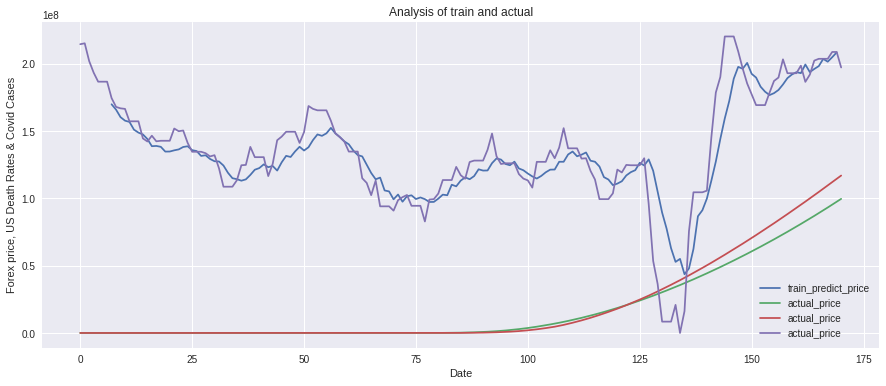

In [ ]:
look_back = 7

trainPredictPlot = np.empty_like(new_dataset)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict

trainPredictPlot = [item[2] for item in trainPredictPlot] 
plt.plot(trainPredictPlot, label="train_predict_price")

train_panda = pd.DataFrame(train_data)
plt.plot(scaler.inverse_transform(train_panda), label="actual_price")

plt.title('Analysis of train and actual')
plt.ylabel('Forex price, US Death Rates & Covid Cases')
plt.xlabel('Date')
plt.legend()
plt.show()



## Custom 21 day prediction (21 is the length of our validation dataset)

*   Training train data to predict future days and evaluating the accuracy on validation data.
*   Training train data to predict future days, no way of evaluating however this can tell us what is likely to occur.
*   Using last 7 days of training data to predict the future custom days(21). 



In [ ]:
# Taking the last 7 days of test
# print(test_data[80:])
# is this supposed to be test or train_data
X_input=test_data[100:].reshape(1,-1)
print(X_input)
X_input.shape
temp_input = train_data[-7:] # start, end 
temp_input



[]


array([[0.36645219, 0.43112686, 0.85231116],
       [0.37508234, 0.44124607, 0.85794814],
       [0.38382006, 0.45143297, 0.85794814],
       [0.39264009, 0.46164599, 0.85794814],
       [0.40154418, 0.47189386, 0.87936866],
       [0.41054811, 0.48221551, 0.87936866],
       [0.41965969, 0.4926037 , 0.83089064]])

In [ ]:
print(len(valset_data))

21


In [ ]:
# Demonstrate prediction for the next 4 days:


# Step 1. 7 days of feature = temp_input taken from the last 7 days of the training set
# Step 2  i is the day you are on and we want to predict 4 days: 0,1,2,3 (4 days)
# Step 3. Predict the 8th day on each of the 7 days,
# Step 4. Add this new predicted day to the list
# Step 5. Because we are now taking in the last 7 days + the new predicted value, the list is now size 8  
# Step 6. In order to take in 7 days at a time, we shift 1 to the right.
# Step 7. We reassign the X_train to the new 7 days
# Step 8. We predict the 8th day of the 7 days and continue the process
# Step 9. We then add the 8th day to the output list
# Step 10. We keep track of the 4 days by incrementing by i at the end-> i = i+1
# Step 11. Once we have predicted the 4 days, we return the list of 4 day values.

from numpy import array
custom_day = len(valset_data)
lst_output=[]
n_steps=7
i=0
X_input = temp_input
while(i<custom_day):
  if(len(temp_input)>7):
    X_input=array(temp_input[1:])
    X_input=X_input.reshape((1,n_steps,3, 1))    # Prediction of X_input
    Y_hat = best_param_model.predict(X_input)
    # print(Y_hat)
    temp_input = np.append(temp_input, Y_hat)
    temp_input=temp_input[1:]
    lst_output.append(Y_hat[0][0])
    i=i+1
  else:
    X_input=X_input.reshape((1,n_steps,3, 1))
    Y_hat = best_param_model.predict(X_input, verbose=0)
    temp_input = np.append(temp_input, Y_hat)
    lst_output.append(Y_hat[0][0])
    i=i+1
print(lst_output)     # Print the predicted forex price for the next 4 days 

[0.87688404, 0.774987, 0.67258674, 0.90625846, 0.8620725, 0.8460574, 0.9857811, 0.92047864, 0.92310745, 1.0314411, 1.0016986, 0.8951773, 1.0229249, 1.1874982, 1.0463314, 1.024816, 1.1240305, 1.0536507, 1.1234859, 1.2029772, 1.1911727]


### Plotting evaluation: Training Prediction of 21 days Versus 21 days of Validation Data.

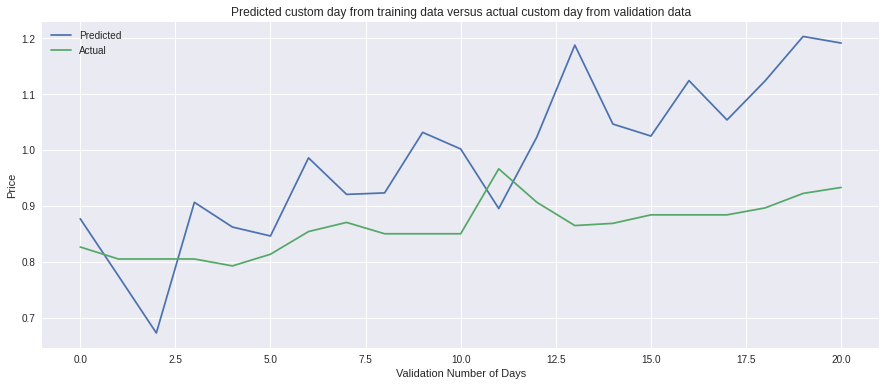

In [ ]:
# Custom day plotted
day_new = custom_day-1

# Predicted 4 days from training
# Plot and label
# Transform back to original value before normalised
custom_day_prediction = np.array(lst_output)
plt.plot(custom_day_prediction, label="Predicted")

val_data = [item[2] for item in valset_data] 
custom_day_validation = val_data[:custom_day]
plt.plot(custom_day_validation, label="Actual")

# Information
plt.title('Predicted custom day from training data versus actual custom day from validation data')
plt.xlabel('Validation Number of Days')
plt.ylabel('Price')
plt.legend()
plt.show()


## Test Plot

14


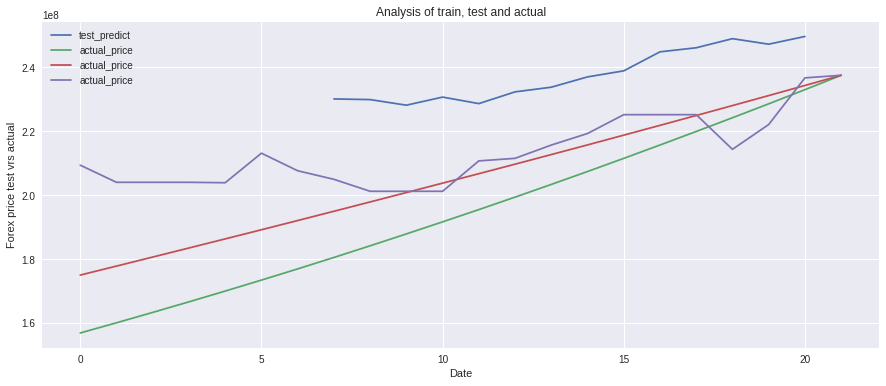

In [ ]:
# Taking in the 7 
look_back = 7

testPredictPlot = np.empty_like(new_dataset)
testPredictPlot[:,:]= np.nan
print(len(test_predict))

testPredictPlot[look_back:len(test_predict)+look_back] = test_predict
testPredictPlot = [item[2] for item in testPredictPlot] 
plt.plot(testPredictPlot, label="test_predict")

test_panda = pd.DataFrame(test_data)
plt.plot(scaler.inverse_transform(test_panda), label="actual_price")

plt.title('Analysis of train, test and actual')
plt.ylabel('Forex price test vrs actual')
plt.xlabel('Date')
plt.legend()
plt.show()

## Plotting Predicted Train, Test, Validation on Graph as well as Actual Dataset

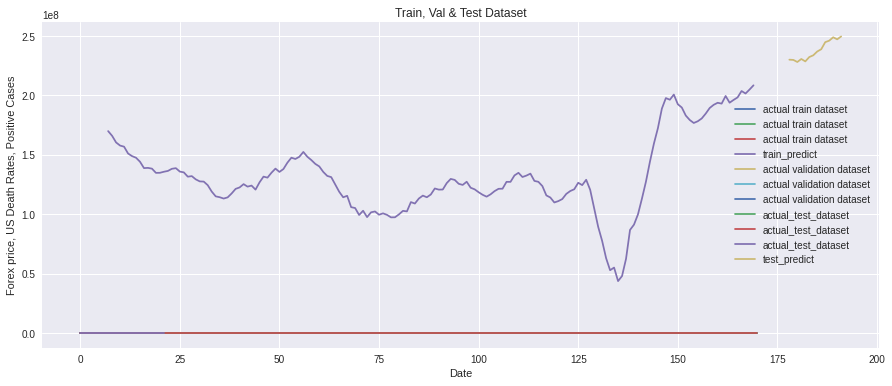

In [ ]:
# All of the above + actual data
# Problem why is this not printing out right?
# How can I make my legends tidier?

# Start
plt.plot(train_data, label="actual train dataset")
# Predicted Train
trainPredictPlot = np.empty_like(new_dataset)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
trainPredictPlot = [item[2] for item in trainPredictPlot] 
plt.plot(trainPredictPlot, label="train_predict")

# Middle
plt.plot(valset_data, label="actual validation dataset")
# insert predicted val

# End
plt.plot(test_data, label="actual_test_dataset")
# Predicted
testPredictPlot = np.empty_like(new_dataset)
testPredictPlot[:,:]= np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1: (training_size + test_size)] = test_predict
testPredictPlot = [item[0] for item in testPredictPlot] 
plt.plot(testPredictPlot, label="test_predict")
# insert predict test

# as you can see th test data and train is divided because we want to test after a specific day
plt.title('Train, Val & Test Dataset')
plt.ylabel('Forex price, US Death Rates, Positive Cases')
plt.xlabel('Date')
plt.legend()
plt.show()

# Conclusion and next steps
After exploring the CNN algorithm:

*   I started working on this project with a very skeptical mind. I was not sure if the images would have enough information/patterns for the ConvNet to find. I especially loved the way they converted the time series problem to image classification.
*   Notes on CNN & small dataset
*   Notes on CNN & overfitting
*   Potential for future work in dealing with small datasets: Bayesian Neural Nets


In conclusion it seems that ..